### Imports

In [1]:
import numpy as np

import sys

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter

from astropy import units as u
from astropy import constants as const
from astropy.table import QTable

from pathlib import Path
import os

import import_ipynb
from Analysis_functions import extract_data, means_calc, stream_crossing, easy_interpolate, \
     stream_alignment_step1, stream_alignment_step2, stream_shape, binned_relative_difference, \
     inertia_tensor, Iii, Iij, aspect_ratios

from Visualization_functions import snapshots_plot, anim_disc, anim_3d, anim_ComparetoTraceback

sys.path.insert(0, '/home/emelie/Desktop/Codes/PETAR/PeTar-master/tools/')
from analysis import *

importing Jupyter notebook from Analysis_functions.ipynb
importing Jupyter notebook from Visualization_functions.ipynb


In [2]:
plt.rcParams.update({'xtick.labelsize':20, 'ytick.labelsize':20, 'axes.titlesize':26, 
                     'axes.grid':True, 'axes.labelsize':24, 'legend.fontsize':20})

### Core evolution incomplete function

In [3]:
def core_evolution(rmin, rmax, n_shells, in_pos, in_mean_pos, data):
    """
    Parameters:
    -----------
    rmin: int or float
        The minimum considered radius of the core
    
    rmax: int or float
        The maximum considered radius of the core
        
    n_shells: int
        Number of core shells to use to calculate evolution as a function of radius
    
    in_pos: array
        Initial positions of particles in galaxy
        
    in_mean_pos: array
        Initial mean position of galaxy (found in PETAR header)
        
    data: array
        All data for all particles in all snapshots
    ------------------------------------------------------------------------------------
    """
    
    # Centering galaxy in coordinate system using header positions
    centered_data = in_pos - in_mean_pos
    
    # Calculating distance from the center to all particles in galaxy
    r_parts = np.sqrt(np.sum(centered_data**2, axis=1))
    
    # Array of all core radii
    core_radii = np.linspace(rmin, rmax, n_shells)
    
    # Mean core distances for all cores for all snapshots, shape:(n_snapshots, core_radii)
    mean_core_dists = np.empty((len(data[0, 0, :]), len(core_radii)))
    # Mean position of the core for all snapshots, shape:(n_snapshots, 3), 3 = x, y, z
    core_mean_pos = np.empty((len(data[0, 0, :]), 3))
    # shapes: (n_snapshots, n_cores)
    a_vals = np.empty((len(data[0, 0, :]), len(core_radii)))
    b_vals = np.empty((len(data[0, 0, :]), len(core_radii)))
    c_vals = np.empty((len(data[0, 0, :]), len(core_radii)))
    
    # Loops over different core radii, calculations for all snapshots are done in one go
    for i, core_rad in enumerate(core_radii):      
        # Which particles are inside certain radius of core
        core_part_rows = np.where(r_parts<=(core_rad))[0]

        # Extracting core particles' data for all timesteps
        core_parts_all_steps = data[core_part_rows, :, :]
        # Shape (n_core_part, 3, n_snapshots) ##(N, 3, 1) now (N, 3, 40)
        core_pos = core_parts_all_steps[:, 1:4, :] 
        
        
        #print(f'{np.shape(core_pos) = }')
        
        # Calculating mean distances between core particles for all timesteps
        # ----------------------------------------------------------------------------------------------
        pos_diffs = core_pos[:, np.newaxis, :, :] - core_pos[np.newaxis, :, :, :]
        #print(f'{np.shape(pos_diffs) = }')
        
        # Calculates the r-distance between all core particles
        # This gives a double-sided square array divided by the diagonal, which is 0
        # Shape: (n_core_part, n_core_part, n_snapshots)
        pos_dists = np.linalg.norm(pos_diffs, axis=2)
        #print(f'{np.shape(pos_dists) = }')
        
        # Shape: (n_snapshots)
        pos_mean_dists = np.mean(pos_dists[np.triu_indices(len(core_pos), k=1)], axis=0)
        #print(f'{np.shape(pos_mean_dists) = }')
        
        mean_core_dists[:, i] = pos_mean_dists#[:, np.newaxis]
        
        
        
        # Mean core position over time
        # ----------------------------------------------------------------------------------------
        if i==0:
            core_mean_pos[:, :] = np.mean(core_pos, axis=0).T # Should get shape (N_snapshots, 3)
        
        
        
        # Inertia tensor and aspect ratios
        # ---------------------------------------------------------------------------------------------
        #for j in range(len(data[0, 0, :])):
            #print(j)
            # Shape (n_core_part, 1)
            #core_masses = core_parts_all_steps[:, 0, j]
            #print(core_masses)
            #print(np.shape(core_masses))
            #print(np.shape(core_pos[:, :, j]))
            #row, col = np.shape(core_pos[:, :, j])
            #core_pos_tstep = core_pos[:, :, j] #np.reshape(core_pos[:, :, j], (row, col))
            #print(core_pos_tstep)
            #print(np.max(core_pos_tstep[:, 0]) - np.min(core_pos_tstep[:, 0]))
            #print(np.max(core_pos_tstep[:, 1]) - np.min(core_pos_tstep[:, 1]))
            #print(np.max(core_pos_tstep[:, 2]) - np.min(core_pos_tstep[:, 2]))
            #core_in_tensor = inertia_tensor(core_masses, core_pos_tstep)
            #print(core_in_tensor)
            #core_eig_vals, core_eig_vec = np.linalg.eig(core_in_tensor)
            
            
            #fig = plt.figure(figsize=(8, 8))
            #ax = fig.add_subplot(projection='3d')

            #ax.scatter(core_pos_tstep[:, 0], core_pos_tstep[:, 1], core_pos_tstep[:, 2], c='b', s=10)
            #lims = 10
            ##ax.set_xlim(-lims, lims)
            ##ax.set_ylim(-lims, lims)
            ##ax.set_zlim(-lims, lims)
            
            #ax.set_xlabel('x', labelpad=20)
            #ax.set_ylabel('y', labelpad=20)
            #ax.set_zlabel('z', labelpad=20)

            #ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
            #ax.xaxis.get_major_formatter().set_powerlimits((0, 0))
            #ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
            #ax.yaxis.get_major_formatter().set_powerlimits((0, 0))
            #ax.zaxis.set_major_formatter(ScalarFormatter(useMathText=True))
            #ax.zaxis.get_major_formatter().set_powerlimits((0, 0))

            #plt.show()

            #eig1 = np.min(core_eig_vals)
            #eig3 = np.max(core_eig_vals)
            #eig2_pos = np.where((core_eig_vals!=np.min(core_eig_vals))&(core_eig_vals!=np.max(core_eig_vals)))[0]
            #eig2 = core_eig_vals[eig2_pos][0]
            #print(eig1, eig2, eig3)
            #print()

            #a_vals[j, i], b_vals[j, i], c_vals[j, i] = aspect_ratios(eig1, eig2, eig3, np.sum(core_masses))
            #print(a_vals[j, i])
            
    
    # Shape (n_snapshots, n_cores, 3)
    #core_aspect_ratios = np.concatenate([a_vals[:, :, np.newaxis], b_vals[:, :, np.newaxis], c_vals[:, :, np.newaxis]], axis=2)
    
    return core_mean_pos, mean_core_dists

# Fiducial model

## Trace back of Boo III Orbit, 3 particles, 1Gyr back in time

In [4]:
fid_trace_back_data, fid_trace_back_header, fid_trace_back_extra, fid_trace_back_hist_data = extract_data(r'btest2_data', r'Petar_back_test2', 125, 1)

print(fid_trace_back_data.shape)
print(fid_trace_back_extra.shape)
print(fid_trace_back_header.shape)

fid_trace_back_halfmass_r = fid_trace_back_extra[0, :]
#print(fid_trace_back_halfmass_r)

print(np.max(fid_trace_back_halfmass_r))
print(np.min(fid_trace_back_halfmass_r))

v_mean_fid_trace_back, r_mean_fid_trace_back = means_calc(fid_trace_back_header)

print(v_mean_fid_trace_back.shape)
print(r_mean_fid_trace_back.shape)

Number of particles is conserved: True
(3, 21, 126)
(4, 126)
(8, 126)
0.014934474300677339
0.0006077755205047432
(126,)
(126,)


## Trace forward of Boo III Orbit, 3 particles, 7Gyr forward in time

In [5]:
fid_trace_forward_data, fid_trace_forward_header, fid_trace_forward_extra, fid_trace_forward_hist_data = extract_data(r'Trace_forward_fiducial_run_data', r'Trace_forward_fiducial_run', 2000, 1)

print(fid_trace_forward_data.shape)
print(fid_trace_forward_extra.shape)
print(fid_trace_forward_header.shape)

fid_trace_forward_halfmass_r = fid_trace_forward_extra[0, :]
#print(fid_trace_forward_halfmass_r)

print(np.max(fid_trace_forward_halfmass_r))
print(np.min(fid_trace_forward_halfmass_r))

v_mean_fid_trace_forward, r_mean_fid_trace_forward = means_calc(fid_trace_forward_header)

print(v_mean_fid_trace_forward.shape)
print(r_mean_fid_trace_forward.shape)

Number of particles is conserved: True
(3, 21, 2001)
(4, 2001)
(8, 2001)
0.06259852657480973
0.0001785783876411207
(2001,)
(2001,)


## Fiducial model run, large: 997967particles, 5Gyr forward

Leo T-like progenitor in Boo III's orbit. Using data without uncertainties:

- $v_{r} = 197.5 \,$km$\,$s$^{-1}$
- $d = 46.5 \,$kpc
- Maschberger 2012 IMF with masses above $2.955 \,$M$_{\odot}$

In [6]:
%%time
fid_mod_data, fid_mod_header, fid_mod_extra, fid_mod_hist_data = extract_data(r'fiducial_large_run_restart', 
                                                                                          r'Fiducial_large_run', 39, 1)

print(fid_mod_data.shape)
print(fid_mod_extra.shape)
print(fid_mod_header.shape)
print(fid_mod_header[:, -1])

fid_mod_halfmass_r = fid_mod_extra[0, :]
print(fid_mod_halfmass_r)

print(np.max(fid_mod_halfmass_r))
print(np.min(fid_mod_halfmass_r))

v_mean_fid_mod, r_mean_fid_mod = means_calc(fid_mod_header)

print(v_mean_fid_mod.shape)
print(r_mean_fid_mod.shape)

Number of particles is conserved: True
(997967, 21, 40)
(4, 40)
(8, 40)
[ 9.97967000e+05  4.99200000e+03  3.64234249e+01  1.54196121e+02
 -4.55313932e+01  6.32416793e+00  2.68520305e+01  1.52638686e+01]
[0.153      0.15276683 0.15336661 0.15311921 0.15286926 0.15284386
 0.15261422 0.15604073 0.16189008 0.16159944 0.1619651  0.16149155
 0.16171636 0.16166781 0.16194518 0.16181718 0.16147825 0.16168146
 0.16167951 0.16185507 0.16203091 0.16209706 0.16172908 0.16163228
 0.1619337  0.16194958 0.16202614 0.16203248 0.16178022 0.16065999
 0.17233712 0.17102987 0.1705406  0.17107929 0.17096251 0.17082212
 0.17165203 0.17136892 0.17183307 0.17223316]
0.17233712202666315
0.15261422246373507
(40,)
(40,)
CPU times: user 11min 19s, sys: 25.5 s, total: 11min 45s
Wall time: 11min 41s


###

In [7]:
num_shells = 5
fid_core_mean_pos, fid_core_mean_size = core_evolution(rmin=2.17e-3, rmax=2.17e-3*num_shells, n_shells=num_shells, 
                                                       in_pos=fid_mod_data[:, 1:4, 0], 
                                                       in_mean_pos=fid_mod_header[2:5, 0], 
                                                       data=fid_mod_data)

In [8]:
print(np.shape(fid_core_mean_pos))
print(np.shape(fid_core_mean_size))

(40, 3)
(40, 5)


In [9]:
fid_core_mean_r = np.sqrt(np.sum(fid_core_mean_pos**2, axis=1))

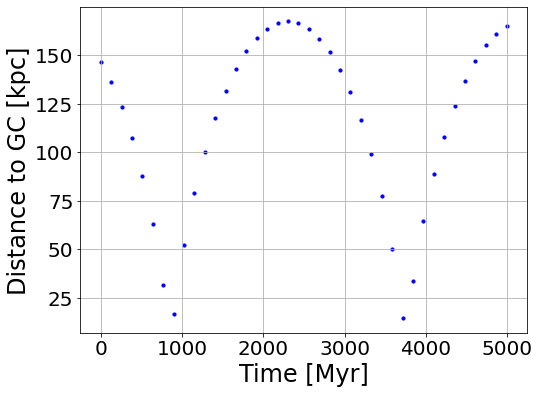

In [10]:
figt1, axt1 = plt.subplots(figsize=(8, 6))

tsteps = np.arange(0, 40, 1)*128

axt1.scatter(tsteps, fid_core_mean_r, s=10, c='b')

axt1.set_xlabel('Time [Myr]')
axt1.set_ylabel('Distance to GC [kpc]')

plt.show()

### Plotting snapshots

snapshots = [0, 14, 27, -1]
snapshots_plot(fid_mod_data, snapshots, 25.0e1, 25.0e1, (11, 20), 1, 'Fiducial_model', 
               save=False)

### Plotting trace forward orbit

tff = trace forward fiducial

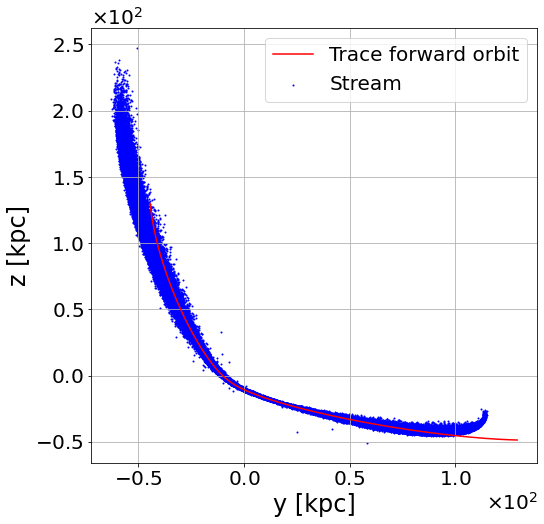

In [21]:
figtff, axtff = plt.subplots(figsize=(8, 8))
#axtff = figtff.add_subplot(projection='3d')

fid_low_tstep = 750
fid_high_tstep = 1135

axtff.plot(fid_trace_forward_data[0, 2, fid_low_tstep:fid_high_tstep], 
           fid_trace_forward_data[0, 3, fid_low_tstep:fid_high_tstep], color='r', label='Trace forward orbit', 
           zorder=10)

axtff.scatter(fid_mod_data[:, 2, 29], fid_mod_data[:, 3, 29], c='b', s=1, zorder=0, label='Stream')


axtff.set_xlabel('y [kpc]') #, labelpad=15)
axtff.set_ylabel('z [kpc]') #, labelpad=15)
#axtff.set_zlabel('z [kpc]', labelpad=5)
axtff.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtff.xaxis.get_major_formatter().set_powerlimits((0, 0))
axtff.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtff.yaxis.get_major_formatter().set_powerlimits((0, 0))
#axtff.zaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#axtff.zaxis.get_major_formatter().set_powerlimits((0, 0))

axtff.legend()


#axtff.view_init(4, 15)

plt.show()

### Constructing orbit data array for high $v_r$ model

In [30]:
upper_part_mask = np.where(fid_mod_data[:, 3, 29] == np.max(fid_mod_data[:, 3, 29]))
# Position (x, y, z, vx, vy, vz) of highest stream particle
upper_part_pos = fid_mod_data[upper_part_mask, 1:7, 29].flatten() 
upper_part_pos = np.concatenate([upper_part_pos, [1]])
print(np.shape(upper_part_pos))
# Highest orbit particle is in the first particle I include
# Getting position and velocity of highest orbit particle
upper_orb_part = fid_trace_forward_data[0, 1:7, fid_low_tstep]
upper_orb_part = np.concatenate([upper_orb_part, [1]])
print(np.shape(upper_orb_part))

fid_orbit_pos_extension = np.concatenate([upper_part_pos[np.newaxis, :], upper_orb_part[np.newaxis, :]], 
                                             axis=0)
print(np.shape(fid_orbit_pos_extension))

(7,)
(7,)
(2, 7)


In [31]:
# Interpolate more points between these two points
for i in range(8):
        #print(i)
        # Roll particles to get x1-x2, x2-x3, etc.
        data_rolled = np.roll(fid_orbit_pos_extension, shift=1, axis=0) 
        
        # Delete first particle because of mismatch: xn-x1
        data = np.delete(fid_orbit_pos_extension, 0, axis=0) 
        data_rolled = np.delete(data_rolled, 0, axis=0)
        #print(data_rolled[:10])
        #print(data[:10])
        
        # Calculating middle point position: x, y, z
        interp_pos = (data_rolled[:, 0:3] + data[:, 0:3])/2 
        
        # Length of data with added points in between
        len_new_data = 2*len(fid_orbit_pos_extension)-1
        #print(len_new_data)

        # x, y, z, vx, vy, vz, t
        new_data = np.zeros((len_new_data, 7))
        
        # Adding data for new points
        new_data[0::2, :] = fid_orbit_pos_extension
        new_data[1::2, 0:3] = interp_pos
        new_data[1::2, 4:] = np.ones((np.shape(new_data[1::2, 4:])))
        
        fid_orbit_pos_extension = new_data
        

In [32]:
print(np.shape(fid_orbit_pos_extension))

(257, 7)


In [33]:
fid_orbit_position = fid_trace_forward_header[2:5, fid_low_tstep:fid_high_tstep].T # To get shape (N,x)
fid_orbit_velocity = fid_trace_forward_header[5:8, fid_low_tstep:fid_high_tstep].T # To get shape (N,x)
fid_orbit_times = fid_trace_forward_header[1, fid_low_tstep:fid_high_tstep].T # To get shape (N,x)

# gets columns (x, y, z, vx, vy, vz, t)
fid_orbit_data1 = np.concatenate([fid_orbit_position, fid_orbit_velocity, fid_orbit_times[:, np.newaxis]], axis=1)

print(np.shape(fid_orbit_data1)) # Expect shape n,7


fid_orbit_data = np.concatenate([fid_orbit_pos_extension, fid_orbit_data1], axis=0)
print(np.shape(fid_orbit_data))

(385, 7)
(642, 7)


### Interpolating orbit

In [34]:
interpolated_fid_orbit = easy_interpolate(fid_orbit_data, 2)
print(np.shape(interpolated_fid_orbit))
#print(interpolated_high_vr_orbit[:20, 3:6])

(2565, 8)


/tmp/ipykernel_3307972/1069897917.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(sc)


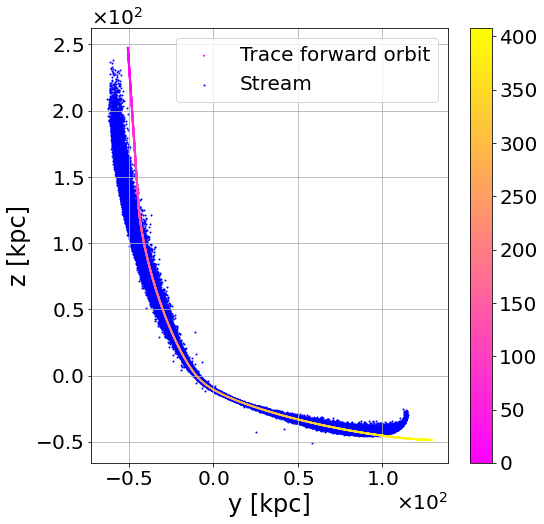

In [35]:
figtff2, axtff2 = plt.subplots(figsize=(8, 8))
#axtff2 = figtfh2.add_subplot(projection='3d')

#axtff2.plot(interpolated_high_vr_orbit[:, 1], interpolated_high_vr_orbit[:, 2], color='r', 
#            label='Trace forward orbit', zorder=10)
sc = axtff2.scatter(interpolated_fid_orbit[:, 1], interpolated_fid_orbit[:, 2], 
                    c=interpolated_fid_orbit[:, -1], cmap='spring', 
                    label='Trace forward orbit', zorder=10, s=1)
plt.colorbar(sc)
axtff2.scatter(fid_mod_data[:, 2, 29], fid_mod_data[:, 3, 29], c='b', s=1, zorder=0, label='Stream')


axtff2.set_xlabel('y [kpc]') #, labelpad=15)
axtff2.set_ylabel('z [kpc]') #, labelpad=15)
#axtff2.set_zlabel('z [kpc]', labelpad=5)
axtff2.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtff2.xaxis.get_major_formatter().set_powerlimits((0, 0))
axtff2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtff2.yaxis.get_major_formatter().set_powerlimits((0, 0))
#axtff2.zaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#axtff2.zaxis.get_major_formatter().set_powerlimits((0, 0))

axtff2.legend()


plt.show()

### Streatching out stream

In [36]:
# Has columns x, y, z, vx, vy, vz
fid_stream_data = fid_mod_data[:, 1:7, 29]
fid_orbital_data = np.delete(interpolated_fid_orbit, 6, axis=1) # Removing time from orbital data as it is not needed

In [37]:
fid_aligned1 = stream_alignment_step1(fid_orbital_data, fid_stream_data)
print('St1 DONE')
fid_aligned2 = stream_alignment_step2(fid_orbital_data, fid_aligned1)
print('St2 DONE')

fid_length, fid_width, fid_part_dens = stream_shape(fid_orbital_data, fid_aligned2)
print('DONE')

Differences calculated
St1 DONE


/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


St2 DONE
DONE


In [38]:
fid_variance = np.round(np.sum(fid_aligned1[:, -2])/len(fid_aligned1), 2)

print(fid_variance)

0.49


# High $v_r$ 

## Trace back of Boo III Orbit, 3 particles, 1Gyr back in time

In [39]:
high_vr_trace_back_data, high_vr_trace_back_header, high_vr_trace_back_extra, high_vr_trace_back_hist_data = extract_data(r'Trace_back_high_vr_run_data', r'Trace_back_high_vr', 125, 1)

print(high_vr_trace_back_data.shape)
print(high_vr_trace_back_extra.shape)
print(high_vr_trace_back_header.shape)

high_vr_trace_back_halfmass_r = high_vr_trace_back_extra[0, :]
#print(high_vr_trace_back_halfmass_r)

print(np.max(high_vr_trace_back_halfmass_r))
print(np.min(high_vr_trace_back_halfmass_r))

v_mean_high_vr_trace_back, r_mean_high_vr_trace_back = means_calc(high_vr_trace_back_header)

print(v_mean_high_vr_trace_back.shape)
print(r_mean_high_vr_trace_back.shape)

Number of particles is conserved: True
(3, 21, 126)
(4, 126)
(8, 126)
0.043533689140061
3.978443332717329e-05
(126,)
(126,)


In [14]:
#anim_3d(high_vr_trace_back_data, high_vr_trace_back_header, tstep=8, nsteps=125, lims=15.0e1, fsize=(10, 10), 
#        marker_size=10, tx=-0.5e2, ty=1.0e2, tz=1.0e2, format_type='mp4', fps=10, run='Trace_back_high_vr_run')

## Trace forward of Boo III Orbit, 3 particles, 8Gyr forward in time

In [40]:
high_vr_trace_forward_data, high_vr_trace_forward_header, high_vr_trace_forward_extra, high_vr_trace_forward_hist_data = extract_data(r'Trace_forward_high_vr_run_data', r'Trace_forward_high_vr', 2000, 1)

print(high_vr_trace_forward_data.shape)
print(high_vr_trace_forward_extra.shape)
print(high_vr_trace_forward_header.shape)

high_vr_trace_forward_halfmass_r = high_vr_trace_forward_extra[0, :]
#print(high_vr_trace_forward_halfmass_r)

print(np.max(high_vr_trace_forward_halfmass_r))
print(np.min(high_vr_trace_forward_halfmass_r))

v_mean_high_vr_trace_forward, r_mean_high_vr_trace_forward = means_calc(high_vr_trace_forward_header)

print(v_mean_high_vr_trace_forward.shape)
print(r_mean_high_vr_trace_forward.shape)

Number of particles is conserved: True
(3, 21, 2001)
(4, 2001)
(8, 2001)
0.15194743234266173
9.209741989690651e-05
(2001,)
(2001,)


In [16]:
#anim_3d(high_vr_trace_forward_data, high_vr_trace_forward_header, tstep=4, nsteps=2000, lims=17.5e1, fsize=(10, 10), 
#        marker_size=10, tx=-0.5e2, ty=1.0e2, tz=1.0e2, format_type='mp4', fps=25, run='Trace_forward_high_vr_run')

## High $v_r$ model run, large: 1000420 particles, 5Gyr forward

Leo T-like progenitor in Boo III's orbit. Using data without uncertainties:

- $v_{r} = 201.3 \,$km$\,$s$^{-1}$
- $d = 46.5 \,$kpc
- Maschberger 2012 IMF with masses above $2.955 \,$M$_{\odot}$

In [41]:
%%time
high_vr_mod_data, high_vr_mod_header, high_vr_mod_extra, high_vr_mod_hist_data = extract_data(r'High_vr_run_data', 
                                                                                          r'High_vr_run', 39, 1)

print(high_vr_mod_data.shape)
print(high_vr_mod_extra.shape)
print(high_vr_mod_header.shape)
print(high_vr_mod_header[:, -1])

high_vr_mod_halfmass_r = high_vr_mod_extra[0, :]
print(high_vr_mod_halfmass_r)

print(np.max(high_vr_mod_halfmass_r))
print(np.min(high_vr_mod_halfmass_r))

v_mean_high_vr_mod, r_mean_high_vr_mod = means_calc(high_vr_mod_header)

print(v_mean_high_vr_mod.shape)
print(r_mean_high_vr_mod.shape)

Number of particles is conserved: True
(1000420, 21, 40)
(4, 40)
(8, 40)
[ 1.00042000e+06  4.99200000e+03  3.33740369e+01  1.47248733e+02
 -5.47703552e+01  1.51643880e+01  6.68709424e+01 -6.74238057e-01]
[0.15299996 0.1528267  0.15310655 0.15274895 0.15297967 0.15268212
 0.15268    0.15584113 0.16170106 0.1614375  0.16194468 0.16166858
 0.16165224 0.16143188 0.16191019 0.16189243 0.16177534 0.16172882
 0.16129697 0.16187332 0.16169414 0.1613252  0.16201086 0.16159458
 0.16207559 0.1616319  0.16199305 0.16181323 0.16149142 0.1618973
 0.16196546 0.16166151 0.1742776  0.17130082 0.17087329 0.17117332
 0.17131419 0.17128246 0.17140711 0.17143778]
0.17427760350876673
0.15267999760051013
(40,)
(40,)
CPU times: user 11min 19s, sys: 26.1 s, total: 11min 45s
Wall time: 11min 42s


In [42]:
num_shells = 5
high_vr_core_mean_pos, high_vr_core_mean_size = core_evolution(rmin=2.17e-3, rmax=2.17e-3*num_shells, n_shells=num_shells, 
                                                       in_pos=high_vr_mod_data[:, 1:4, 0], 
                                                       in_mean_pos=high_vr_mod_header[2:5, 0], 
                                                       data=high_vr_mod_data)

In [43]:
print(np.shape(high_vr_core_mean_pos))
print(np.shape(high_vr_core_mean_size))

(40, 3)
(40, 5)


In [44]:
high_vr_core_mean_r = np.sqrt(np.sum(high_vr_core_mean_pos**2, axis=1))

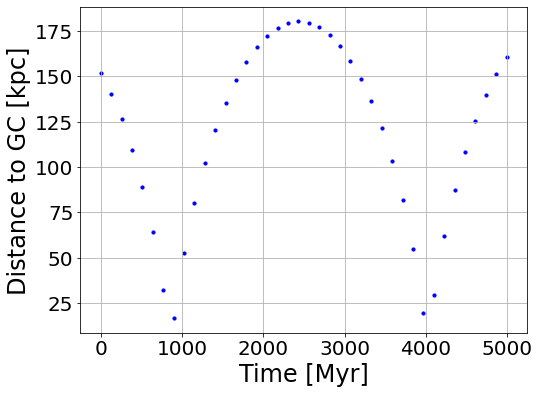

In [45]:
figt2, axt2 = plt.subplots(figsize=(8, 6))

tsteps = np.arange(0, 40, 1)*128

axt2.scatter(tsteps, high_vr_core_mean_r, s=10, c='b')

axt2.set_xlabel('Time [Myr]')
axt2.set_ylabel('Distance to GC [kpc]')

plt.show()

###

### Plotting snapshots

snapshots = [0, 14, 27, -1]
snapshots_plot(high_vr_mod_data, snapshots, 25.0e1, 25.0e1, (11, 20), 1, 'High_vr_model', 
               save=False)

### Plotting trace forward orbit

tfh = trace forward high (vr)

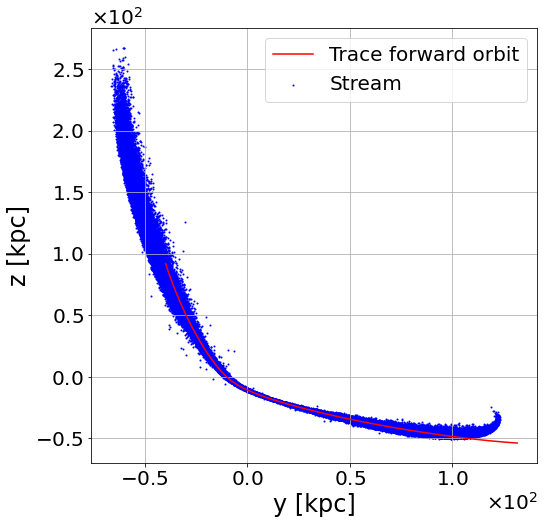

In [55]:
figtfh, axtfh = plt.subplots(figsize=(8, 8))
#axtfh = figtfh.add_subplot(projection='3d')

high_vr_low_tstep = 900 # 650 before
high_vr_high_tstep = 1200

axtfh.plot(high_vr_trace_forward_data[0, 2, high_vr_low_tstep:high_vr_high_tstep], 
           high_vr_trace_forward_data[0, 3, high_vr_low_tstep:high_vr_high_tstep], color='r', 
           label='Trace forward orbit', zorder=10)

axtfh.scatter(high_vr_mod_data[:, 2, 31], high_vr_mod_data[:, 3, 31], c='b', s=1, zorder=0, label='Stream')


axtfh.set_xlabel('y [kpc]') #, labelpad=15)
axtfh.set_ylabel('z [kpc]') #, labelpad=15)
#axtfh.set_zlabel('z [kpc]', labelpad=5)
axtfh.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtfh.xaxis.get_major_formatter().set_powerlimits((0, 0))
axtfh.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtfh.yaxis.get_major_formatter().set_powerlimits((0, 0))
#axtfh.zaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#axtfh.zaxis.get_major_formatter().set_powerlimits((0, 0))

axtfh.legend()


plt.show()

### Constructing orbit data array for high $v_r$ model

In [56]:
upper_part_mask = np.where(high_vr_mod_data[:, 3, 31] == np.max(high_vr_mod_data[:, 3, 31]))
# Position (x, y, z, vx, vy, vz) of highest stream particle
upper_part_pos = high_vr_mod_data[upper_part_mask, 1:7, 31].flatten() 
upper_part_pos = np.concatenate([upper_part_pos, [1]])
print(np.shape(upper_part_pos))
# Highest orbit particle is in the first particle I include
# Getting position and velocity of highest orbit particle
upper_orb_part = high_vr_trace_forward_data[0, 1:7, high_vr_low_tstep]
upper_orb_part = np.concatenate([upper_orb_part, [1]])
print(np.shape(upper_orb_part))

high_vr_orbit_pos_extension = np.concatenate([upper_part_pos[np.newaxis, :], upper_orb_part[np.newaxis, :]], 
                                             axis=0)
print(np.shape(high_vr_orbit_pos_extension))

(7,)
(7,)
(2, 7)


In [57]:
# Interpolate more points between these two points
for i in range(8):
        #print(i)
        # Roll particles to get x1-x2, x2-x3, etc.
        data_rolled = np.roll(high_vr_orbit_pos_extension, shift=1, axis=0) 
        
        # Delete first particle because of mismatch: xn-x1
        data = np.delete(high_vr_orbit_pos_extension, 0, axis=0) 
        data_rolled = np.delete(data_rolled, 0, axis=0)
        #print(data_rolled[:10])
        #print(data[:10])
        
        # Calculating middle point position: x, y, z
        interp_pos = (data_rolled[:, 0:3] + data[:, 0:3])/2 
        
        # Length of data with added points in between
        len_new_data = 2*len(high_vr_orbit_pos_extension)-1
        #print(len_new_data)

        # x, y, z, vx, vy, vz, t
        new_data = np.zeros((len_new_data, 7))
        
        # Adding data for new points
        new_data[0::2, :] = high_vr_orbit_pos_extension
        new_data[1::2, 0:3] = interp_pos
        new_data[1::2, 4:] = np.ones((np.shape(new_data[1::2, 4:])))
        
        high_vr_orbit_pos_extension = new_data
        

In [58]:
print(np.shape(high_vr_orbit_pos_extension))

(257, 7)


In [59]:
high_vr_orbit_position = high_vr_trace_forward_header[2:5, high_vr_low_tstep:high_vr_high_tstep].T # To get shape (N,x)
high_vr_orbit_velocity = high_vr_trace_forward_header[5:8, high_vr_low_tstep:high_vr_high_tstep].T # To get shape (N,x)
high_vr_orbit_times = high_vr_trace_forward_header[1, high_vr_low_tstep:high_vr_high_tstep].T # To get shape (N,x)

# gets columns (x, y, z, vx, vy, vz, t)
high_vr_orbit_data1 = np.concatenate([high_vr_orbit_position, high_vr_orbit_velocity, high_vr_orbit_times[:, np.newaxis]], axis=1)

print(np.shape(high_vr_orbit_data1)) # Expect shape n,7


high_vr_orbit_data = np.concatenate([high_vr_orbit_pos_extension, high_vr_orbit_data1], axis=0)
print(np.shape(high_vr_orbit_data))

(300, 7)
(557, 7)


### Interpolating orbit

In [60]:
interpolated_high_vr_orbit = easy_interpolate(high_vr_orbit_data, 2)
print(np.shape(interpolated_high_vr_orbit))
#print(interpolated_high_vr_orbit[:20, 3:6])

(2225, 8)


<string>:31: RuntimeWarning: divide by zero encountered in true_divide


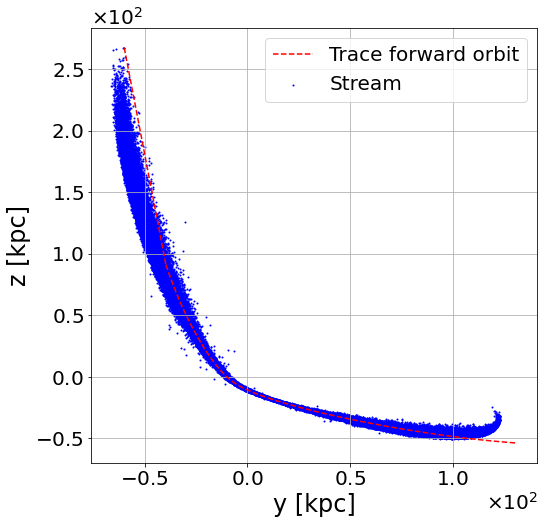

In [164]:
figtfh2, axtfh2 = plt.subplots(figsize=(8, 8))
#axtfh2 = figtfh2.add_subplot(projection='3d')

axtfh2.plot(interpolated_high_vr_orbit[:, 1], interpolated_high_vr_orbit[:, 2], color='r', 
            label='Trace forward orbit', zorder=10, linestyle='dashed')
#sc = axtfh2.scatter(interpolated_high_vr_orbit[:, 1], interpolated_high_vr_orbit[:, 2], 
#                    c=interpolated_high_vr_orbit[:, -1], cmap='spring', 
#                    label='Trace forward orbit', zorder=10, s=1)
#plt.colorbar(sc)
axtfh2.scatter(high_vr_mod_data[:, 2, 31], high_vr_mod_data[:, 3, 31], c='b', s=1, zorder=0, label='Stream')


axtfh2.set_xlabel('y [kpc]') #, labelpad=15)
axtfh2.set_ylabel('z [kpc]') #, labelpad=15)
#axtfh2.set_zlabel('z [kpc]', labelpad=5)
axtfh2.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtfh2.xaxis.get_major_formatter().set_powerlimits((0, 0))
axtfh2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtfh2.yaxis.get_major_formatter().set_powerlimits((0, 0))
#axtfh2.zaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#axtfh2.zaxis.get_major_formatter().set_powerlimits((0, 0))

axtfh2.legend()


plt.show()

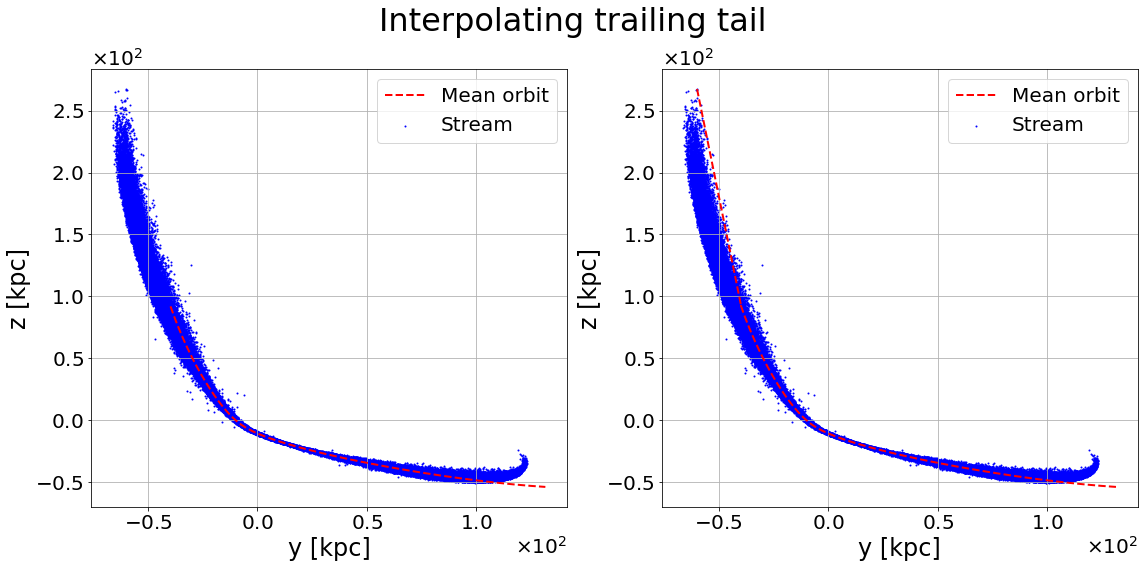

In [176]:
figtfh3, axtfh3 = plt.subplots(1, 2, figsize=(16, 8))


#high_vr_low_tstep = 900 
#high_vr_high_tstep = 1200

axtfh3[0].plot(high_vr_trace_forward_data[0, 2, high_vr_low_tstep:high_vr_high_tstep], 
           high_vr_trace_forward_data[0, 3, high_vr_low_tstep:high_vr_high_tstep], color='r', 
           label='Mean orbit', zorder=10, linestyle='dashed', lw=2)

axtfh3[0].scatter(high_vr_mod_data[:, 2, 31], high_vr_mod_data[:, 3, 31], c='b', s=1, zorder=0, label='Stream')


axtfh3[0].set_xlabel('y [kpc]') 
axtfh3[0].set_ylabel('z [kpc]') 
#axtfh3[0].set_title('Before interpolating trailing tail')
axtfh3[0].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtfh3[0].xaxis.get_major_formatter().set_powerlimits((0, 0))
axtfh3[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtfh3[0].yaxis.get_major_formatter().set_powerlimits((0, 0))

axtfh3[0].legend()





axtfh3[1].plot(interpolated_high_vr_orbit[:, 1], interpolated_high_vr_orbit[:, 2], color='r', 
            label='Mean orbit', zorder=10, linestyle='dashed', lw=2)

axtfh3[1].scatter(high_vr_mod_data[:, 2, 31], high_vr_mod_data[:, 3, 31], c='b', s=1, zorder=0, label='Stream')


axtfh3[1].set_xlabel('y [kpc]')
axtfh3[1].set_ylabel('z [kpc]')
#axtfh3[1].set_title('After interpolating trailing tail')
axtfh3[1].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtfh3[1].xaxis.get_major_formatter().set_powerlimits((0, 0))
axtfh3[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtfh3[1].yaxis.get_major_formatter().set_powerlimits((0, 0))

axtfh3[1].legend()


plt.suptitle('Interpolating trailing tail', fontsize=32)

plt.tight_layout()
plt.savefig('./Plots/Interpolating_trailing_tail_example.png', facecolor='w', bbox_inches='tight')
plt.show()

### Making animations

In [178]:
#%%time
#anim_3d(high_vr_mod_data, high_vr_mod_header, tstep=128, 
#        nsteps=39+1, lims=25.0e1, fsize=(10, 10), 
#        marker_size=1, tx=-1.5e2, ty=2.0e2, tz=2.0e2, 
#        format_type='mp4', fps=6, run='High_vr_model')

In [184]:
#anim_ComparetoTraceback(high_vr_mod_data, high_vr_trace_back_data, lims=2.5e2, 
#                        run_file='High_vr_run_and_trace_back', run_title='High vr run compared to trace back',
#                        fsize=(10, 10), fps=2, format_type='mp4')

### Streatching out stream

In [62]:
# Has columns x, y, z, vx, vy, vz
high_vr_stream_data = high_vr_mod_data[:, 1:7, 31]
high_vr_orbital_data = np.delete(interpolated_high_vr_orbit, 6, axis=1) # Removing time from orbital data as it is not needed

In [63]:
print(interpolated_high_vr_orbit[:, -1])

[0.00000000e+00 3.44974746e-01 5.17462120e-01 ... 4.32448295e+02
 4.32544373e+02 4.32544373e+02]


In [64]:
high_vr_aligned1 = stream_alignment_step1(high_vr_orbital_data, high_vr_stream_data)
print('St1 DONE')
high_vr_aligned2 = stream_alignment_step2(high_vr_orbital_data, high_vr_aligned1)
print('St2 DONE')

high_vr_length, high_vr_width, high_vr_part_dens = stream_shape(high_vr_orbital_data, high_vr_aligned2)
print('DONE')

Differences calculated
St1 DONE


/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


St2 DONE
DONE


In [65]:
high_vr_variance = np.round(np.sum(high_vr_aligned1[:, -2])/len(high_vr_aligned1), 2)

print(high_vr_variance)

0.55


# Low $v_r$

In [66]:
low_vr_trace_back_data, low_vr_trace_back_header, low_vr_trace_back_extra, low_vr_trace_back_hist_data = extract_data(r'Trace_back_low_vr_run_data', r'Trace_back_low_vr', 125, 1)

print(low_vr_trace_back_data.shape)
print(low_vr_trace_back_extra.shape)
print(low_vr_trace_back_header.shape)

low_vr_trace_back_halfmass_r = low_vr_trace_back_extra[0, :]
#print(low_vr_trace_back_halfmass_r)

print(np.max(low_vr_trace_back_halfmass_r))
print(np.min(low_vr_trace_back_halfmass_r))

v_mean_low_vr_trace_back, r_mean_low_vr_trace_back = means_calc(low_vr_trace_back_header)

print(v_mean_low_vr_trace_back.shape)
print(r_mean_low_vr_trace_back.shape)

Number of particles is conserved: True
(3, 21, 126)
(4, 126)
(8, 126)
0.03700917319870922
8.01049871450461e-05
(126,)
(126,)


In [29]:
#anim_3d(low_vr_trace_back_data, low_vr_trace_back_header, tstep=8, nsteps=125, lims=15.0e1, fsize=(10, 10), 
#        marker_size=10, tx=-0.5e2, ty=1.0e2, tz=1.0e2, format_type='mp4', fps=10, run='Trace_back_low_vr_run')#

## Trace forward of Boo III Orbit, 3 particles, 8Gyr forward in time

In [67]:
low_vr_trace_forward_data, low_vr_trace_forward_header, low_vr_trace_forward_extra, low_vr_trace_forward_hist_data = extract_data(r'Trace_forward_low_vr_run_data', r'Trace_forward_low_vr', 2000, 1)

print(low_vr_trace_forward_data.shape)
print(low_vr_trace_forward_extra.shape)
print(low_vr_trace_forward_header.shape)

low_vr_trace_forward_halfmass_r = low_vr_trace_forward_extra[0, :]
#print(low_vr_trace_forward_halfmass_r)

print(np.max(low_vr_trace_forward_halfmass_r))
print(np.min(low_vr_trace_forward_halfmass_r))

v_mean_low_vr_trace_forward, r_mean_low_vr_trace_forward = means_calc(low_vr_trace_forward_header)

print(v_mean_low_vr_trace_forward.shape)
print(r_mean_low_vr_trace_forward.shape)

Number of particles is conserved: True
(3, 21, 2001)
(4, 2001)
(8, 2001)
2.453716093484886
3.692823107296476e-05
(2001,)
(2001,)


In [31]:
#anim_3d(low_vr_trace_forward_data, low_vr_trace_forward_header, tstep=4, nsteps=2000, lims=17.5e1, fsize=(10, 10), 
#        marker_size=10, tx=-0.5e2, ty=1.0e2, tz=1.0e2, format_type='mp4', fps=20, run='Trace_forward_low_vr_run')

## Low $v_r$ model run, large: 999618 particles, 5Gyr forward

Leo T-like progenitor in Boo III's orbit. Using data without uncertainties:

- $v_{r} = 193.7 \,$km$\,$s$^{-1}$
- $d = 46.5 \,$kpc
- Maschberger 2012 IMF with masses above $2.955 \,$M$_{\odot}$

In [68]:
%%time
low_vr_mod_data, low_vr_mod_header, low_vr_mod_extra, low_vr_mod_hist_data = extract_data(r'Low_vr_run_data', 
                                                                                          r'Low_vr_run', 39, 1)

print(low_vr_mod_data.shape)
print(low_vr_mod_extra.shape)
print(low_vr_mod_header.shape)
print(low_vr_mod_header[:, -1])

low_vr_mod_halfmass_r = low_vr_mod_extra[0, :]
print(low_vr_mod_halfmass_r)

print(np.max(low_vr_mod_halfmass_r))
print(np.min(low_vr_mod_halfmass_r))

v_mean_low_vr_mod, r_mean_low_vr_mod = means_calc(low_vr_mod_header)

print(v_mean_low_vr_mod.shape)
print(r_mean_low_vr_mod.shape)

Number of particles is conserved: True
(999618, 21, 40)
(4, 40)
(8, 40)
[ 9.99618000e+05  4.99200000e+03  3.79055697e+01  1.53857884e+02
 -4.66028082e+01  7.40147248e+00  3.01941196e+01  1.41338965e+01]
[0.153      0.15312431 0.1529584  0.15291814 0.15304198 0.15293964
 0.15263226 0.15657494 0.16179169 0.16176256 0.16127576 0.16132883
 0.16182141 0.16152997 0.16166275 0.16187225 0.1614298  0.16162745
 0.16187415 0.16139353 0.16167504 0.16171149 0.16148045 0.16197508
 0.16158689 0.16183615 0.16172224 0.16174623 0.16154642 0.16108165
 0.17328471 0.17061134 0.17054103 0.17065474 0.17044331 0.17085046
 0.17100264 0.17142486 0.17156914 0.17180488]
0.17328470904978588
0.15263226140723077
(40,)
(40,)
CPU times: user 11min 23s, sys: 26 s, total: 11min 49s
Wall time: 11min 45s


In [69]:
num_shells = 5
low_vr_core_mean_pos, low_vr_core_mean_size = core_evolution(rmin=2.17e-3, rmax=2.17e-3*num_shells, n_shells=num_shells, 
                                                       in_pos=low_vr_mod_data[:, 1:4, 0], 
                                                       in_mean_pos=low_vr_mod_header[2:5, 0], 
                                                       data=low_vr_mod_data)

In [70]:
print(np.shape(low_vr_core_mean_pos))
print(np.shape(low_vr_core_mean_size))

(40, 3)
(40, 5)


In [71]:
low_vr_core_mean_r = np.sqrt(np.sum(low_vr_core_mean_pos**2, axis=1))

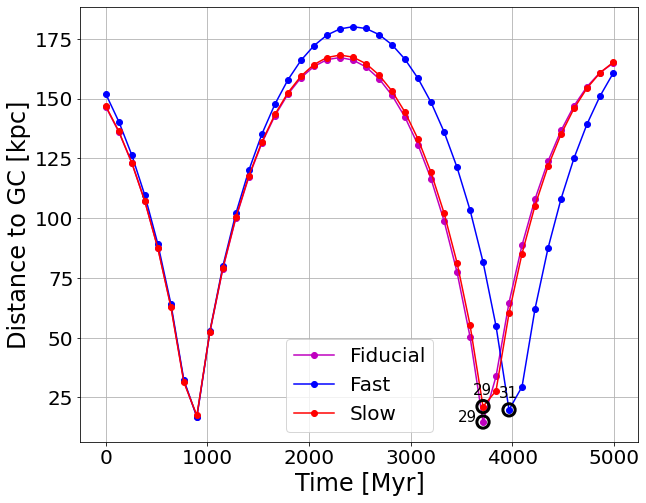

In [72]:
figt3, axt3 = plt.subplots(figsize=(10, 8))

tsteps = np.arange(0, 40, 1)*128

axt3.plot(tsteps, fid_core_mean_r, color='m', marker='o', label='Fiducial')
axt3.scatter(tsteps[29], fid_core_mean_r[29], edgecolor='k', marker='o', s=150, linewidth=3, facecolor='none',
            zorder=20)
axt3.text(tsteps[29]-250, fid_core_mean_r[29], '29', fontsize=15)

axt3.plot(tsteps, high_vr_core_mean_r, color='b', marker='o', label='Fast')
axt3.scatter(tsteps[31], high_vr_core_mean_r[31], edgecolor='k', marker='o', s=150, linewidth=3, facecolor='none',
            zorder=20)
axt3.text(tsteps[31]-100, high_vr_core_mean_r[31]+5, '31', fontsize=15)

axt3.plot(tsteps, low_vr_core_mean_r, color='r', marker='o', label='Slow')
axt3.scatter(tsteps[29], low_vr_core_mean_r[29], edgecolor='k', marker='o', s=150, linewidth=3, facecolor='none',
            zorder=20)
axt3.text(tsteps[29]-100, low_vr_core_mean_r[29]+5, '29', fontsize=15)


axt3.set_xlabel('Time [Myr]')
axt3.set_ylabel('Distance to GC [kpc]')

axt3.legend()

plt.savefig('./Plots/Distance_from_GC_and_tsteps_vr.png', facecolor='w', bbox_inches='tight')
plt.show()

###

### Plotting snapshots

snapshots = [0, 14, 27, -1]
snapshots_plot(low_vr_mod_data, snapshots, 25.0e1, 25.0e1, (11, 20), 1, 'Low_vr_model', 
               save=False)

### Plotting orbit

tfl = trace forward low (vr)

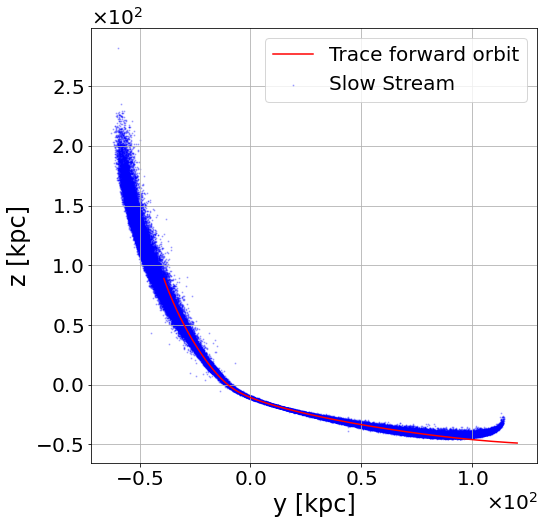

In [82]:
figtfl, axtfl = plt.subplots(figsize=(8, 8))
#axtfl = figtfl.add_subplot(projection='3d')

low_vr_low_tstep = 850
low_vr_high_tstep = 1125

axtfl.plot(low_vr_trace_forward_data[0, 2, low_vr_low_tstep:low_vr_high_tstep], 
           low_vr_trace_forward_data[0, 3, low_vr_low_tstep:low_vr_high_tstep], color='r', 
           label='Trace forward orbit', zorder=10)

axtfl.scatter(low_vr_mod_data[:, 2, 29], low_vr_mod_data[:, 3, 29], alpha=0.25, c='b', s=1, zorder=0, label='Slow Stream')
#axtfl.scatter(high_vr_mod_data[:, 1, 31], high_vr_mod_data[:, 3, 31], alpha=0.25, c='b', s=1, zorder=0, label='Fast Stream')


axtfl.set_xlabel('y [kpc]') #, labelpad=15)
axtfl.set_ylabel('z [kpc]') #, labelpad=15)
#axtfhlset_zlabel('z [kpc]', labelpad=5)
axtfl.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtfl.xaxis.get_major_formatter().set_powerlimits((0, 0))
axtfl.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtfl.yaxis.get_major_formatter().set_powerlimits((0, 0))
#axtfl.zaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#axtfl.zaxis.get_major_formatter().set_powerlimits((0, 0))

axtfl.legend()

plt.show()

### Constructing orbit data array for high $v_r$ model

In [86]:
low_vr_z_vals = low_vr_mod_data[:, 3, 29]
low_vr_sorted_z_vals = np.sort(low_vr_z_vals)
second_largest_z = low_vr_sorted_z_vals[-2]

upper_part_mask = np.where(low_vr_mod_data[:, 3, 29] == second_largest_z)
# Position (x, y, z, vx, vy, vz) of highest stream particle
upper_part_pos = low_vr_mod_data[upper_part_mask, 1:7, 29].flatten() 
upper_part_pos = np.concatenate([upper_part_pos, [1]])
print(np.shape(upper_part_pos))
# Highest orbit particle is in the first particle I include
# Getting position and velocity of highest orbit particle
upper_orb_part = low_vr_trace_forward_data[0, 1:7, low_vr_low_tstep]
upper_orb_part = np.concatenate([upper_orb_part, [1]])
print(np.shape(upper_orb_part))

low_vr_orbit_pos_extension = np.concatenate([upper_part_pos[np.newaxis, :], upper_orb_part[np.newaxis, :]], 
                                             axis=0)
print(np.shape(low_vr_orbit_pos_extension))

(7,)
(7,)
(2, 7)


In [87]:
# Interpolate more points between these two points
for i in range(8):
        #print(i)
        # Roll particles to get x1-x2, x2-x3, etc.
        data_rolled = np.roll(low_vr_orbit_pos_extension, shift=1, axis=0) 
        
        # Delete first particle because of mismatch: xn-x1
        data = np.delete(low_vr_orbit_pos_extension, 0, axis=0) 
        data_rolled = np.delete(data_rolled, 0, axis=0)
        #print(data_rolled[:10])
        #print(data[:10])
        
        # Calculating middle point position: x, y, z
        interp_pos = (data_rolled[:, 0:3] + data[:, 0:3])/2 
        
        # Length of data with added points in between
        len_new_data = 2*len(low_vr_orbit_pos_extension)-1
        #print(len_new_data)

        # x, y, z, vx, vy, vz, t
        new_data = np.zeros((len_new_data, 7))
        
        # Adding data for new points
        new_data[0::2, :] = low_vr_orbit_pos_extension
        new_data[1::2, 0:3] = interp_pos
        new_data[1::2, 4:] = np.ones((np.shape(new_data[1::2, 4:])))
        
        low_vr_orbit_pos_extension = new_data
        

In [88]:
print(np.shape(low_vr_orbit_pos_extension))

(257, 7)


In [93]:
low_vr_orbit_position = low_vr_trace_forward_header[2:5, low_vr_low_tstep:low_vr_high_tstep].T # To get shape (N,x)
low_vr_orbit_velocity = low_vr_trace_forward_header[5:8, low_vr_low_tstep:low_vr_high_tstep].T # To get shape (N,x)
low_vr_orbit_times = low_vr_trace_forward_header[1, low_vr_low_tstep:low_vr_high_tstep].T # To get shape (N,x)

# gets columns (x, y, z, vx, vy, vz, t)
low_vr_orbit_data1 = np.concatenate([low_vr_orbit_position, low_vr_orbit_velocity, low_vr_orbit_times[:, np.newaxis]], axis=1)

print(np.shape(low_vr_orbit_data1)) # Expect shape n,7


low_vr_orbit_data = np.concatenate([low_vr_orbit_pos_extension, low_vr_orbit_data1], axis=0)
print(np.shape(low_vr_orbit_data))

(275, 7)
(532, 7)


### Interpolating orbit

In [94]:
interpolated_low_vr_orbit = easy_interpolate(low_vr_orbit_data, 2)
print(np.shape(interpolated_low_vr_orbit))
#print(interpolated_low_vr_orbit[:20, 3:6])

(2125, 8)


/tmp/ipykernel_3307972/466696865.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(sc)


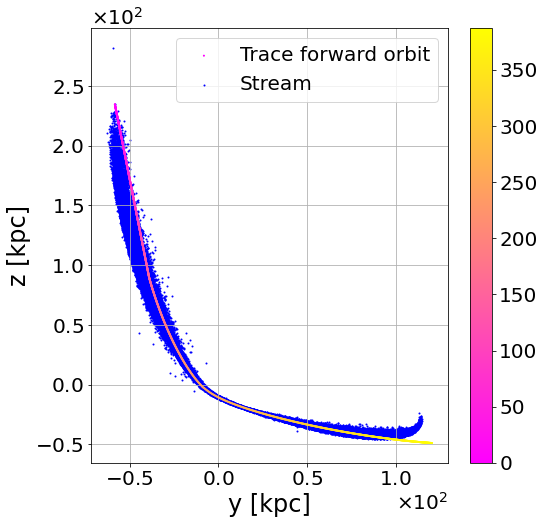

In [95]:
figtfl2, axtfl2 = plt.subplots(figsize=(8, 8))
#axtfl2 = figtfl2.add_subplot(projection='3d')

#axtfl2.plot(interpolated_low_vr_orbit[:, 1], interpolated_low_vr_orbit[:, 2], color='r', 
#            label='Trace forward orbit', zorder=10)
sc = axtfl2.scatter(interpolated_low_vr_orbit[:, 1], interpolated_low_vr_orbit[:, 2], 
                    c=interpolated_low_vr_orbit[:, -1], cmap='spring', 
                    label='Trace forward orbit', zorder=10, s=1)
plt.colorbar(sc)
axtfl2.scatter(low_vr_mod_data[:, 2, 29], low_vr_mod_data[:, 3, 29], c='b', s=1, zorder=0, label='Stream')


axtfl2.set_xlabel('y [kpc]') #, labelpad=15)
axtfl2.set_ylabel('z [kpc]') #, labelpad=15)
#axtfl2.set_zlabel('z [kpc]', labelpad=5)
axtfl2.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtfl2.xaxis.get_major_formatter().set_powerlimits((0, 0))
axtfl2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axtfl2.yaxis.get_major_formatter().set_powerlimits((0, 0))
#axtfl2.zaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#axtfl2.zaxis.get_major_formatter().set_powerlimits((0, 0))

axtfl2.legend()


plt.show()

### Making animations

In [180]:
#%%time
#anim_3d(low_vr_mod_data, low_vr_mod_header, tstep=128, 
#        nsteps=39+1, lims=25.0e1, fsize=(10, 10), 
#        marker_size=1, tx=-1.5e2, ty=2.0e2, tz=2.0e2, 
#        format_type='mp4', fps=6, run='Low_vr_model')

In [182]:
#anim_ComparetoTraceback(low_vr_mod_data, low_vr_trace_back_data, lims=2.5e2, 
#                        run_file='Low_vr_run_and_trace_back', run_title='Low vr run compared to trace back',
#                        fsize=(10, 10), fps=2, format_type='mp4')

### Streatching out stream

In [96]:
# Has columns x, y, z, vx, vy, vz
low_vr_stream_data = low_vr_mod_data[:, 1:7, 29]
low_vr_orbital_data = np.delete(interpolated_low_vr_orbit, 6, axis=1) # Removing time from orbital data as it is not needed

In [97]:
low_vr_aligned1 = stream_alignment_step1(low_vr_orbital_data, low_vr_stream_data)
print('St1 DONE')
low_vr_aligned2 = stream_alignment_step2(low_vr_orbital_data, low_vr_aligned1)
print('St2 DONE')

low_vr_length, low_vr_width, low_vr_part_dens = stream_shape(low_vr_orbital_data, low_vr_aligned2)
print('DONE')

Differences calculated
St1 DONE


/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


St2 DONE
DONE


In [98]:
low_vr_variance = np.round(np.sum(low_vr_aligned1[:, -2])/len(low_vr_aligned1), 2)

print(low_vr_variance)

0.47


In [99]:
print(np.sum(high_vr_trace_forward_data[:, 0, 0]))
print(np.sum(low_vr_trace_forward_data[:, 0, 0]))
print(np.sum(fid_trace_forward_data[:, 0, 0]))

print(np.sum(high_vr_trace_back_data[:, 0, 0]))
print(np.sum(low_vr_trace_back_data[:, 0, 0]))
print(np.sum(fid_trace_back_data[:, 0, 0]))

3.0
3.0
3.0
3.0
3.0
1.1938226541394579


# Comparing streams

### Comparing mean orbits

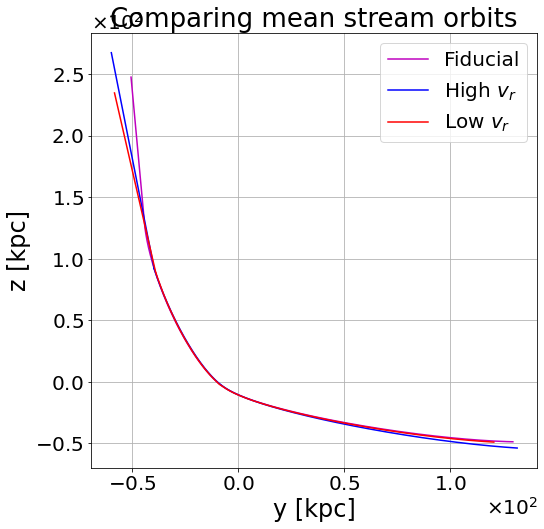

In [100]:
figc4, axc4 = plt.subplots(figsize=(8, 8))

axc4.plot(interpolated_fid_orbit[:, 1], interpolated_fid_orbit[:, 2], color='m', label='Fiducial')
axc4.plot(interpolated_high_vr_orbit[:, 1], interpolated_high_vr_orbit[:, 2], color='b', label=r'High $v_r$')
axc4.plot(interpolated_low_vr_orbit[:, 1], interpolated_low_vr_orbit[:, 2], color='r', label=r'Low $v_r$')


axc4.set_title('Comparing mean stream orbits')
axc4.set_xlabel('y [kpc]')
axc4.set_ylabel('z [kpc]')

axc4.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc4.xaxis.get_major_formatter().set_powerlimits((0, 0))
axc4.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc4.yaxis.get_major_formatter().set_powerlimits((0, 0))


lgnd = axc4.legend()
lgnd.legendHandles[0]._sizes=[30]
lgnd.legendHandles[1]._sizes=[30]
lgnd.legendHandles[2]._sizes=[30]
lgnd.legendHandles[0].set_alpha(1)
lgnd.legendHandles[1].set_alpha(1)
lgnd.legendHandles[2].set_alpha(1)


plt.show()

In [119]:
fid_mid_peak_pos = np.where(fid_part_dens==np.max(fid_part_dens))[0]
#fid_mid_peak_pos = np.where(fid_aligned2[:, -1]==np.min(fid_aligned2[:, -1]))[0]
print(fid_mid_peak_pos)
#print(np.max(fid_width))
fid_orbit_pos = np.where(fid_orbital_data==fid_aligned2[fid_mid_peak_pos, -2])[0]
fid_mean_stream_dist = fid_orbital_data[fid_orbit_pos, -1]
fid_aligned_stream_dist = fid_aligned2[:, -2] - fid_mean_stream_dist

high_vr_mid_peak_pos = np.where(high_vr_part_dens==np.max(high_vr_part_dens))[0]
#high_vr_mid_peak_pos = np.where(high_vr_aligned2[:, -1]==np.min(high_vr_aligned2[:, -1]))[0]
high_vr_orbit_pos = np.where(high_vr_orbital_data==high_vr_aligned2[high_vr_mid_peak_pos, -2])[0]
high_vr_mean_stream_dist = high_vr_orbital_data[high_vr_orbit_pos, -1]
high_vr_aligned_stream_dist = high_vr_aligned2[:, -2] - high_vr_mean_stream_dist

low_vr_mid_peak_pos = np.where(low_vr_part_dens==np.max(low_vr_part_dens))[0]
#low_vr_mid_peak_pos = np.where(low_vr_aligned2[:, -1]==np.min(low_vr_aligned2[:, -1]))[0]
low_vr_orbit_pos = np.where(low_vr_orbital_data==low_vr_aligned2[low_vr_mid_peak_pos, -2])[0]
low_vr_mean_stream_dist = low_vr_orbital_data[low_vr_orbit_pos, -1]
low_vr_aligned_stream_dist = low_vr_aligned2[:, -2] - low_vr_mean_stream_dist

[1739]


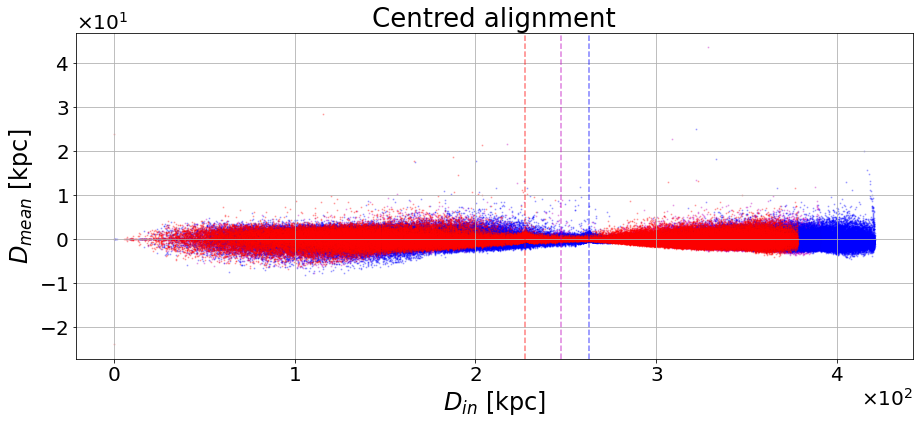

In [121]:
figc5, axc5 = plt.subplots(figsize=(15, 6))

axc5.scatter(fid_aligned2[:, -2], fid_aligned2[:, -1], c='m', s=1, alpha=0.25, label='Fiducial')
axc5.scatter(high_vr_aligned2[:, -2], high_vr_aligned2[:, -1], c='b', s=1, alpha=0.25, label='High_vr')
axc5.scatter(low_vr_aligned2[:, -2], low_vr_aligned2[:, -1], c='r', s=1, alpha=0.25, label='Low_vr')

axc5.axvline(fid_mean_stream_dist, color='m', alpha=0.5, linestyle='dashed')
axc5.axvline(high_vr_mean_stream_dist, color='b', alpha=0.5, linestyle='dashed')
axc5.axvline(low_vr_mean_stream_dist, color='r', alpha=0.5, linestyle='dashed')

#axc5.set_ylim(0, 95)

axc5.set_title('Centred alignment')
axc5.set_xlabel(r'$D_{in}$ [kpc]')
axc5.set_ylabel(r'$D_{mean}$ [kpc]')

axc5.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc5.xaxis.get_major_formatter().set_powerlimits((0, 0))
axc5.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc5.yaxis.get_major_formatter().set_powerlimits((0, 0))


plt.show()

In [126]:
fid_mid_peak_pos = np.where(fid_part_dens==np.max(fid_part_dens))[0]
fid_mean_stream_dist = fid_orbital_data[fid_mid_peak_pos, -1]
fid_aligned_stream_dist = fid_aligned2[:, -2] - fid_mean_stream_dist
fid_aligned_orb_data = fid_orbital_data[:, -1] - fid_mean_stream_dist

high_vr_mid_peak_pos = np.where(high_vr_part_dens==np.max(high_vr_part_dens))[0]
high_vr_mean_stream_dist = high_vr_orbital_data[high_vr_mid_peak_pos, -1]
high_vr_aligned_stream_dist = high_vr_aligned2[:, -2] - high_vr_mean_stream_dist
high_vr_aligned_orb_data = high_vr_orbital_data[:, -1] - high_vr_mean_stream_dist

low_vr_mid_peak_pos = np.where(low_vr_part_dens==np.max(low_vr_part_dens))[0]
low_vr_mean_stream_dist = low_vr_orbital_data[low_vr_mid_peak_pos, -1]
low_vr_aligned_stream_dist = low_vr_aligned2[:, -2] - low_vr_mean_stream_dist
low_vr_aligned_orb_data = low_vr_orbital_data[:, -1] - low_vr_mean_stream_dist

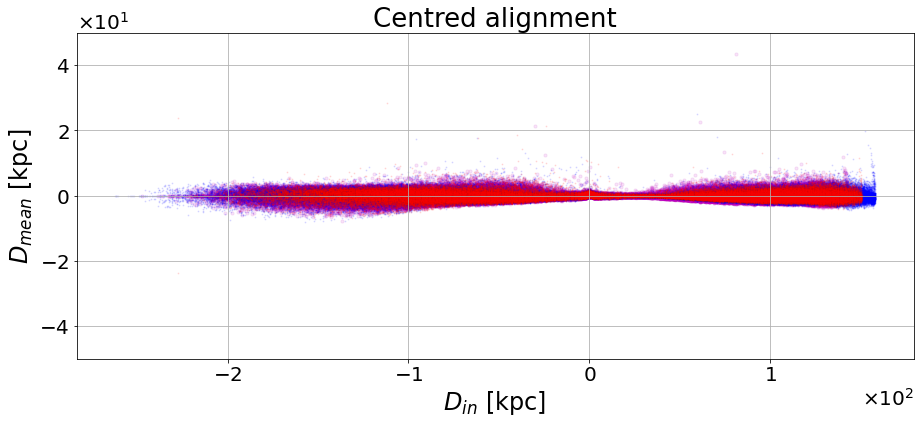

In [123]:
figc52, axc52 = plt.subplots(figsize=(15, 6)) #(15, 6)

axc52.scatter(fid_aligned_stream_dist, fid_aligned2[:, -1], c='m', s=10, alpha=0.1, label='Fiducial')
axc52.scatter(high_vr_aligned_stream_dist, high_vr_aligned2[:, -1], c='b', s=1, alpha=0.1, label='High_vr')
axc52.scatter(low_vr_aligned_stream_dist, low_vr_aligned2[:, -1], c='r', s=1, alpha=0.1, label='Low_vr')

axc52.set_title('Centred alignment')
axc52.set_xlabel(r'$D_{in}$ [kpc]')
axc52.set_ylabel(r'$D_{mean}$ [kpc]')

lims = 50

axc52.set_ylim(ymin=-lims, ymax=lims)



#axc52.scatter(fid_mod_data[:, 2, 29], fid_mod_data[:, 3, 29], c='g', alpha=0.5, s=10, label='Fiducial', 
#             zorder=10)
#axc52.scatter(high_vr_mod_data[:, 2, 31], high_vr_mod_data[:, 3, 31], c='b', alpha=0.5, s=1, label=r'Fast', 
#             zorder=0)
#axc52.scatter(low_vr_mod_data[:, 2, 29], low_vr_mod_data[:, 3, 29], c='r', alpha=0.5, s=1, label=r'Slow', 
#            zorder=20)

#axc52.set_xlabel('y [kpc]')
#axc52.set_ylabel('z [kpc]')
#axc52.legend()

axc52.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc52.xaxis.get_major_formatter().set_powerlimits((0, 0))
axc52.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc52.yaxis.get_major_formatter().set_powerlimits((0, 0))


plt.show()

### Variance (I think)

In [104]:
print(fid_variance, high_vr_variance, low_vr_variance)

0.49 0.55 0.47


### Length

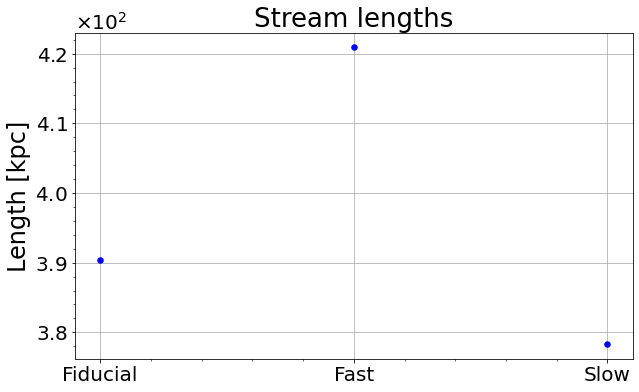

In [105]:
figc1, axc1 = plt.subplots(figsize=(10, 6))

plt.minorticks_on()

x_vals = np.array([1, 2, 3])
y_vals = np.array([fid_length, high_vr_length, low_vr_length])

labels = ["Fiducial", "Fast", "Slow"]


axc1.scatter(x_vals, y_vals, s=30, c='b', zorder=10)

axc1.set_title('Stream lengths')
axc1.set_ylabel('Length [kpc]')

axc1.set_xticks(x_vals, labels=labels)
axc1.set_xticklabels(labels, minor=False)


axc1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc1.yaxis.get_major_formatter().set_powerlimits((0, 0))

plt.grid(zorder=-10)


plt.savefig('./Plots/Length_comparisons_vr.png', facecolor='w')
plt.show()

### Width

In [125]:
print(np.shape(fid_aligned_stream_dist))
print(np.shape(fid_width))

(997967,)
(2565, 1)


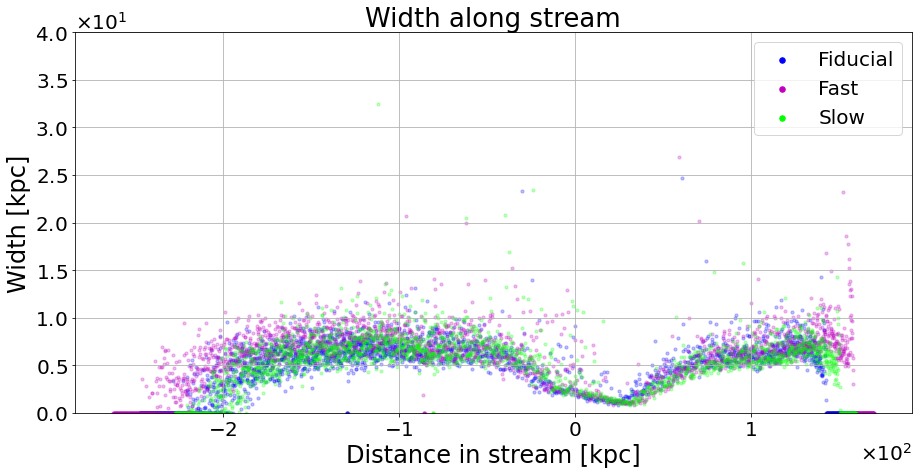

In [127]:
figc2, axc2 = plt.subplots(figsize=(15, 7))

#fid_orbital_data[:, -1]
axc2.scatter(fid_aligned_orb_data, fid_width, c='b', s=10, alpha=0.25, label='Fiducial')
axc2.scatter(high_vr_aligned_orb_data, high_vr_width, c='m', s=10, alpha=0.25, label='Fast')
axc2.scatter(low_vr_aligned_orb_data, low_vr_width, c='lime', s=10, alpha=0.25, label='Slow')


axc2.set_title('Width along stream')
axc2.set_xlabel('Distance in stream [kpc]')
axc2.set_ylabel('Width [kpc]')

axc2.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc2.xaxis.get_major_formatter().set_powerlimits((0, 0))
axc2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc2.yaxis.get_major_formatter().set_powerlimits((0, 0))

axc2.set_ylim(ymin=0, ymax=0.4e2)


lgnd = axc2.legend()
lgnd.legendHandles[0]._sizes=[30]
lgnd.legendHandles[1]._sizes=[30]
lgnd.legendHandles[2]._sizes=[30]
lgnd.legendHandles[0].set_alpha(1)
lgnd.legendHandles[1].set_alpha(1)
lgnd.legendHandles[2].set_alpha(1)

plt.savefig('./Plots/Width_along_stream_comparison_vr.png', facecolor='w')
plt.show()

In [153]:
def binned_relative_difference_vr(stream_prop, stream_data, stream_orbit_data, comp_prop, comp_data, comp_orbit_data, long_orbit_data, n_bins):
    """
    stream_prop, property of stream to compare
    
    stream_data, all data of stream
    
    comp_prop, property of comparison stream to compare
    
    comp_data, all data of comparison stream
    
    al_orbit_data, aligned orbital data for longest mean orbit
    """
    min_stream_length = np.min(long_orbit_data)
    max_stream_length = np.max(long_orbit_data)
    
    # arange for setting bin width instead of number of bins
    bin_edges = np.linspace(min_stream_length, max_stream_length, n_bins)
    
    bin_edges_rolled = np.roll(bin_edges, 1)
    bin_edges_rolled_corr = np.delete(bin_edges_rolled, 0)
    bin_edges_corr = np.delete(bin_edges, 0)
    bin_positions = (bin_edges_rolled_corr + bin_edges_corr)/2
    
    relative_difference = []
    standard_dev = []
    
    for i in range(1, len(bin_edges)):
        #bin_mask_long = (bin_edges[i-1]<=long_orbit_data)&(long_orbit_data<bin_edges[i])
        bin_mask_comp = (bin_edges[i-1]<=comp_orbit_data)&(comp_orbit_data<bin_edges[i])
        bin_mask_stream = (bin_edges[i-1]<=stream_orbit_data)&(stream_orbit_data<bin_edges[i])
        
        #bin_orbit_data_long = long_orbit_data[bin_mask_long]
        property_stream = stream_prop[bin_mask_stream]
        bin_orbit_stream = stream_orbit_data[bin_mask_stream]
        property_comp = comp_prop[bin_mask_comp]
        bin_orbit_comp = comp_orbit_data[bin_mask_comp]
        
        mean_prop_stream = np.median(property_stream)
        mean_prop_comp = np.median(property_comp)
        
        rel_diff_mean = np.abs((mean_prop_comp - mean_prop_stream)/(mean_prop_comp))
        relative_difference.append(rel_diff_mean)
        
        
        # Calculating standard deviation
        stream_std = np.std(property_stream)
        comp_std = np.std(property_comp)
        
        std_den = comp_std + stream_std
        std_frac = rel_diff_mean*(std_den/(mean_prop_comp - mean_prop_stream) + comp_std/mean_prop_comp)
        standard_dev.append(std_frac)
        
    relative_difference = np.array(relative_difference)
    relative_difference[np.isnan(relative_difference)] = 0
    relative_difference[np.isinf(relative_difference)] = np.max(relative_difference)
    
    standard_dev = np.array(standard_dev)
    
    result = np.concatenate([bin_positions[:, np.newaxis], relative_difference[:, np.newaxis], 
                             standard_dev[:, np.newaxis]], axis=1)
    
    return result

In [154]:
nbins=25

diff_fid_hv = binned_relative_difference_vr(high_vr_width, high_vr_aligned2, high_vr_aligned_orb_data, 
                                            fid_width, fid_aligned2, fid_aligned_orb_data, 
                                            high_vr_aligned_orb_data, nbins)

diff_fid_lv = binned_relative_difference_vr(low_vr_width, low_vr_aligned2, low_vr_aligned_orb_data, 
                                            fid_width, fid_aligned2, fid_aligned_orb_data, 
                                            high_vr_aligned_orb_data, nbins)



diff_hv_lv = binned_relative_difference_vr(low_vr_width, low_vr_aligned2, low_vr_aligned_orb_data, 
                                           high_vr_width, high_vr_aligned2, high_vr_aligned_orb_data, 
                                           high_vr_aligned_orb_data, nbins)

/tmp/ipykernel_3307972/1922219779.py:41: RuntimeWarning: invalid value encountered in double_scalars
  rel_diff_mean = np.abs((mean_prop_comp - mean_prop_stream)/(mean_prop_comp))
/tmp/ipykernel_3307972/1922219779.py:52: RuntimeWarning: divide by zero encountered in double_scalars
  std_frac = rel_diff_mean*(std_den/(mean_prop_comp - mean_prop_stream) + comp_std/mean_prop_comp)
/tmp/ipykernel_3307972/1922219779.py:52: RuntimeWarning: invalid value encountered in double_scalars
  std_frac = rel_diff_mean*(std_den/(mean_prop_comp - mean_prop_stream) + comp_std/mean_prop_comp)
/tmp/ipykernel_3307972/1922219779.py:41: RuntimeWarning: divide by zero encountered in double_scalars
  rel_diff_mean = np.abs((mean_prop_comp - mean_prop_stream)/(mean_prop_comp))
/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid valu

/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:3465: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err
/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:3465: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err


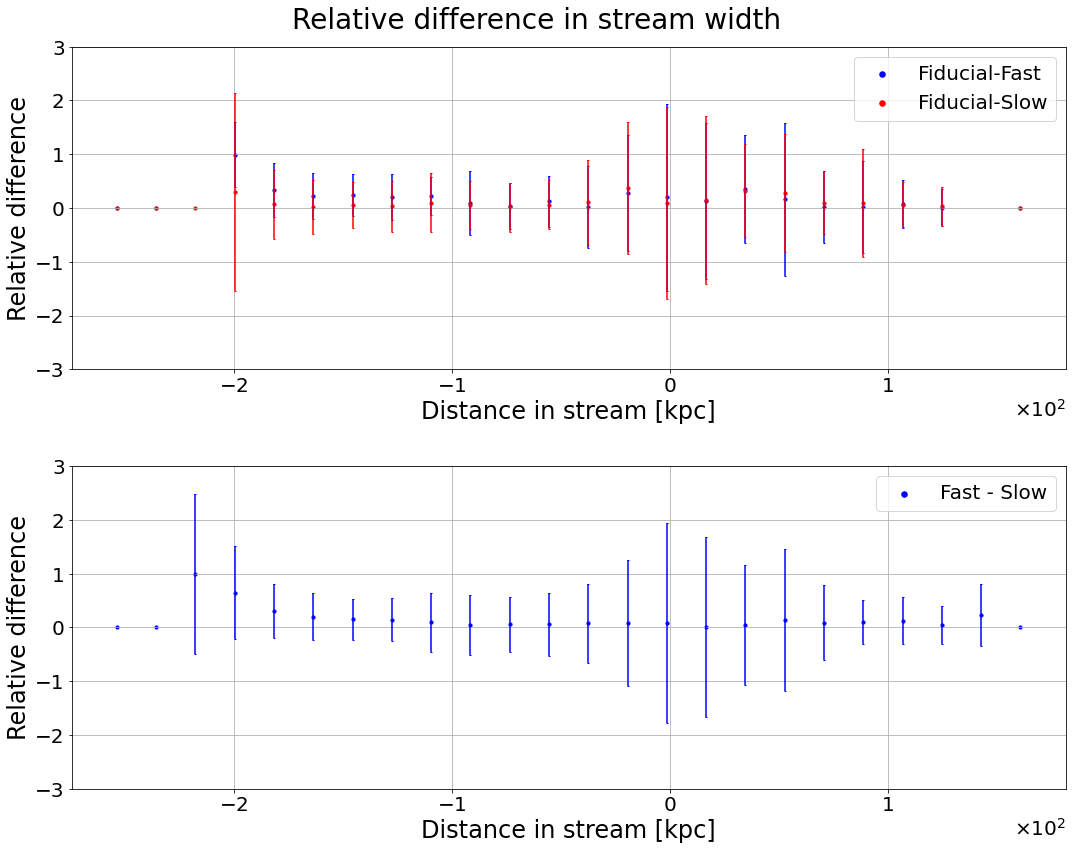

In [156]:
figc22, axc22 = plt.subplots(2, 1, figsize=(15, 12))


# Scatter plot with errorbars
# ------------------------------------------------------------------------------------
axc22[0].scatter(diff_fid_hv[:, 0], diff_fid_hv[:, 1], c='b', label='Fiducial-Fast', s=10)
axc22[0].scatter(diff_fid_lv[:, 0], diff_fid_lv[:, 1], c='r', label='Fiducial-Slow', s=10)


axc22[0].errorbar(diff_fid_hv[:, 0], diff_fid_hv[:, 1], yerr=diff_fid_hv[:, 2], ecolor='b', capsize=1, 
                 linestyle='')
axc22[0].errorbar(diff_fid_lv[:, 0], diff_fid_lv[:, 1], yerr=diff_fid_lv[:, 2], ecolor='r', capsize=1, 
                 linestyle='')

lims0 = 3

axc22[0].set_ylim(ymin=-lims0, ymax=lims0)
axc22[0].set_ylabel('Relative difference')
axc22[0].set_xlabel('Distance in stream [kpc]')

axc22[0].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc22[0].xaxis.get_major_formatter().set_powerlimits((0, 0))


lgnd = axc22[0].legend()
lgnd.legendHandles[0]._sizes=[30]
lgnd.legendHandles[1]._sizes=[30]
lgnd.legendHandles[0].set_alpha(1)
lgnd.legendHandles[1].set_alpha(1)



axc22[1].scatter(diff_hv_lv[:, 0], diff_hv_lv[:, 1], c='b', label=r'Fast - Slow', s=10)

axc22[1].errorbar(diff_hv_lv[:, 0], diff_hv_lv[:, 1], yerr=diff_hv_lv[:, 2], ecolor='b', capsize=1, linestyle='')

lims1 = 3
axc22[1].set_ylim(ymin=-lims1, ymax=lims1)
axc22[1].set_ylabel('Relative difference')
axc22[1].set_xlabel('Distance in stream [kpc]')

axc22[1].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc22[1].xaxis.get_major_formatter().set_powerlimits((0, 0))

lgnd = axc22[1].legend()
lgnd.legendHandles[0]._sizes=[30]
lgnd.legendHandles[0].set_alpha(1)

figc22.suptitle('Relative difference in stream width', fontsize=28)


plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.savefig('./Plots/Relative_differences_width_vr.png', facecolor='w', bbox_inches='tight')
plt.show()

### Particle density

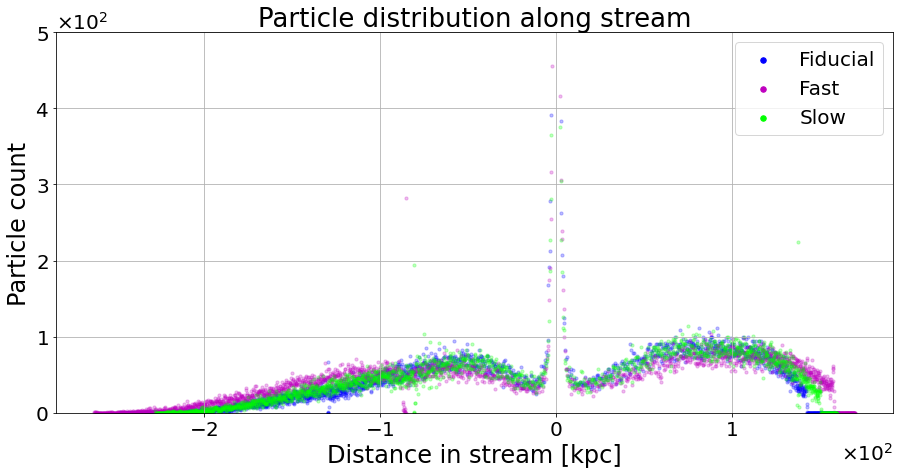

In [157]:
figc3, axc3 = plt.subplots(figsize=(15, 7))
fid_aligned_orb_data
#fid_orbital_data[:, -1]
axc3.scatter(fid_aligned_orb_data, fid_part_dens, c='b', s=10, alpha=0.25, label='Fiducial')
axc3.scatter(high_vr_aligned_orb_data, high_vr_part_dens, c='m', s=10, alpha=0.25, label='Fast')
axc3.scatter(low_vr_aligned_orb_data, low_vr_part_dens, c='lime', s=10, alpha=0.25, label='Slow')


axc3.set_title('Particle distribution along stream')
axc3.set_xlabel('Distance in stream [kpc]')
axc3.set_ylabel('Particle count')

axc3.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc3.xaxis.get_major_formatter().set_powerlimits((0, 0))
axc3.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc3.yaxis.get_major_formatter().set_powerlimits((0, 0))

axc3.set_ylim(ymin=0, ymax=0.5e3)


lgnd = axc3.legend()
lgnd.legendHandles[0]._sizes=[30]
lgnd.legendHandles[1]._sizes=[30]
lgnd.legendHandles[2]._sizes=[30]
lgnd.legendHandles[0].set_alpha(1)
lgnd.legendHandles[1].set_alpha(1)
lgnd.legendHandles[2].set_alpha(1)


plt.savefig('./Plots/Particle_density_along_stream_comparison_vr.png', facecolor='w')
plt.show()

In [160]:
nbins = 25

diff_part_dens_fid_hv = binned_relative_difference_vr(high_vr_part_dens, high_vr_aligned2, high_vr_aligned_orb_data, 
                                                       fid_part_dens, fid_aligned2, fid_aligned_orb_data, 
                                                       high_vr_aligned_orb_data, nbins)

diff_part_dens_fid_lv = binned_relative_difference_vr(low_vr_part_dens, low_vr_aligned2, low_vr_aligned_orb_data, 
                                                       fid_part_dens, fid_aligned2, fid_aligned_orb_data, 
                                                       high_vr_aligned_orb_data, nbins)



diff_part_dens_hv_lv = binned_relative_difference_vr(low_vr_part_dens, low_vr_aligned2, low_vr_aligned_orb_data, 
                                                      high_vr_part_dens, high_vr_aligned2, high_vr_aligned_orb_data, 
                                                      high_vr_aligned_orb_data, nbins)

/tmp/ipykernel_3307972/1922219779.py:41: RuntimeWarning: invalid value encountered in double_scalars
  rel_diff_mean = np.abs((mean_prop_comp - mean_prop_stream)/(mean_prop_comp))
/tmp/ipykernel_3307972/1922219779.py:52: RuntimeWarning: divide by zero encountered in double_scalars
  std_frac = rel_diff_mean*(std_den/(mean_prop_comp - mean_prop_stream) + comp_std/mean_prop_comp)
/tmp/ipykernel_3307972/1922219779.py:41: RuntimeWarning: divide by zero encountered in double_scalars
  rel_diff_mean = np.abs((mean_prop_comp - mean_prop_stream)/(mean_prop_comp))
/tmp/ipykernel_3307972/1922219779.py:52: RuntimeWarning: invalid value encountered in double_scalars
  std_frac = rel_diff_mean*(std_den/(mean_prop_comp - mean_prop_stream) + comp_std/mean_prop_comp)
/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid valu

/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:3465: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err
/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:3465: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err


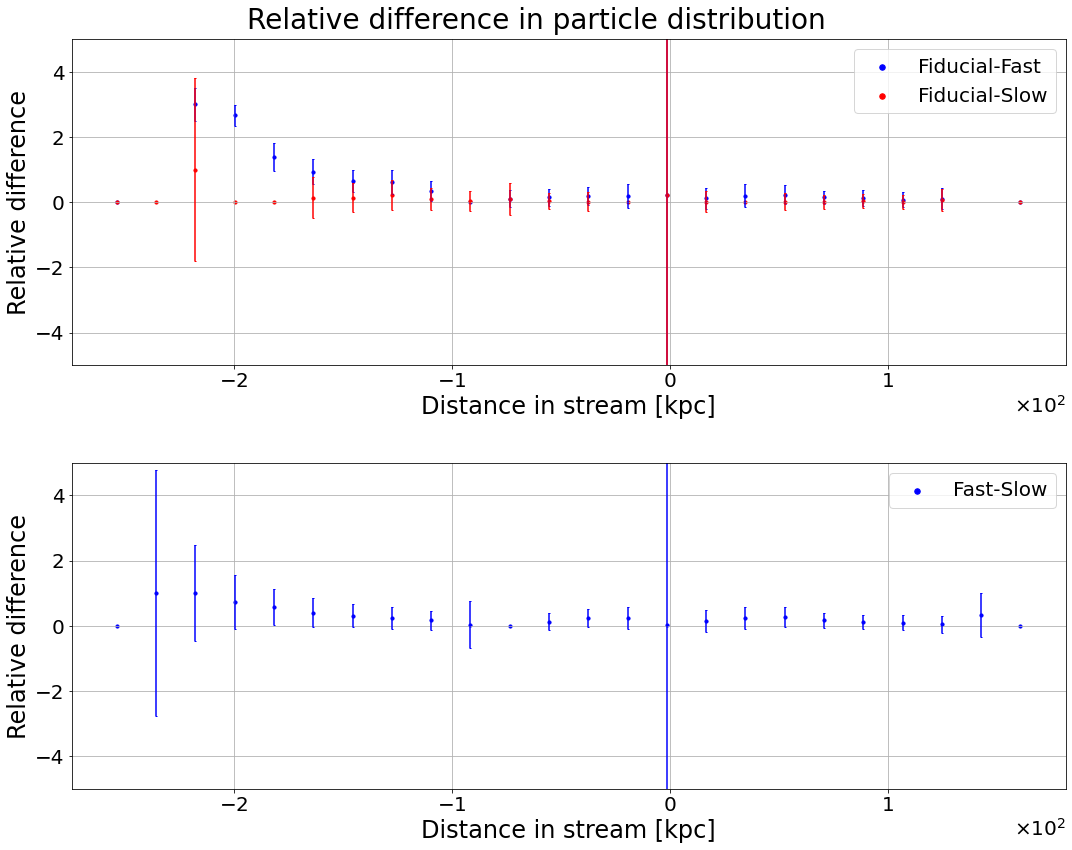

In [162]:
figc32, axc32 = plt.subplots(2, 1, figsize=(15, 12))

axc32[0].scatter(diff_part_dens_fid_hv[:, 0], diff_part_dens_fid_hv[:, 1], c='b', 
                 label='Fiducial-Fast', s=10)
axc32[0].scatter(diff_part_dens_fid_lv[:, 0], diff_part_dens_fid_lv[:, 1], c='r', 
                 label='Fiducial-Slow', s=10)

axc32[0].errorbar(diff_part_dens_fid_hv[:, 0], diff_part_dens_fid_hv[:, 1], yerr=diff_part_dens_fid_hv[:, 2], 
                  ecolor='b', capsize=1, linestyle='')
axc32[0].errorbar(diff_part_dens_fid_lv[:, 0], diff_part_dens_fid_lv[:, 1], yerr=diff_part_dens_fid_lv[:, 2], 
                  ecolor='r', capsize=1, linestyle='')


lims0 = 5
axc32[0].set_ylim(ymin=-lims0, ymax=lims0)
axc32[0].set_ylabel('Relative difference')
axc32[0].set_xlabel('Distance in stream [kpc]')

axc32[0].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc32[0].xaxis.get_major_formatter().set_powerlimits((0, 0))


lgnd = axc32[0].legend()
lgnd.legendHandles[0]._sizes=[30]
lgnd.legendHandles[1]._sizes=[30]
lgnd.legendHandles[0].set_alpha(1)
lgnd.legendHandles[1].set_alpha(1)



axc32[1].scatter(diff_part_dens_hv_lv[:, 0], diff_part_dens_hv_lv[:, 1], c='b', label='Fast-Slow', s=10)


axc32[1].errorbar(diff_part_dens_hv_lv[:, 0], diff_part_dens_hv_lv[:, 1], yerr=diff_part_dens_hv_lv[:, 2], 
                  ecolor='b', capsize=1, linestyle='')

lims1 = 5
axc32[1].set_ylim(ymin=-lims1, ymax=lims1)
axc32[1].set_ylabel('Relative difference')
axc32[1].set_xlabel('Distance in stream [kpc]')

axc32[1].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axc32[1].xaxis.get_major_formatter().set_powerlimits((0, 0))

lgnd = axc32[1].legend()
lgnd.legendHandles[0]._sizes=[30]
lgnd.legendHandles[0].set_alpha(1)

figc32.suptitle('Relative difference in particle distribution', fontsize=28)


plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.savefig('./Plots/Relative_differences_particle_density_vr.png', facecolor='w', bbox_inches='tight')
plt.show()